In [1]:
# Set up GPU rendering.
import distutils.util
import os
import subprocess

# Configure MuJoCo to use the EGL rendering backend (requires GPU)
print('Setting environment variable to use GPU rendering:')
%env MUJOCO_GL=egl

# Check if installation was succesful.
try:
  print('Checking that the installation succeeded:')
  import mujoco
  mujoco.MjModel.from_xml_string('<mujoco/>')
except Exception as e:
  raise e from RuntimeError(
      'Something went wrong during installation. Check the shell output above '
      'for more information.\n'
      'If using a hosted Colab runtime, make sure you enable GPU acceleration '
      'by going to the Runtime menu and selecting "Choose runtime type".')

print('Installation successful.')

# Other imports and helper functions
import time
import itertools
import numpy as np

# Graphics and plotting.
print('Installing mediapy:')
!command -v ffmpeg >/dev/null || (apt update && apt install -y ffmpeg)
!pip install -q mediapy
import mediapy as media
import matplotlib.pyplot as plt

# More legible printing from numpy.
np.set_printoptions(precision=3, suppress=True, linewidth=100)

from IPython.display import clear_output
clear_output()

""

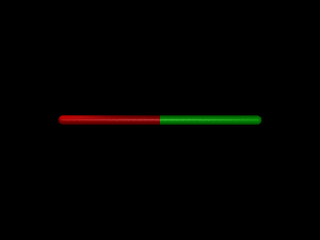

In [2]:
planar_arm = '''
<mujoco>
  <option timestep="0.001" gravity="0 0 0"/>
  
  <default>
    <geom type="capsule" size="0.05"/>
    <joint type="hinge" axis="0 0 1"/>
  </default>

  <worldbody>
    <!-- Base -->
    <light pos="0 -.4 1"/>
    <camera name="fixed" pos="1 -3 0" xyaxes="1 0 0 0 0 1"/>
    <body name="base" pos="0 0 0">
      <!-- First link -->
      <body name="link1" pos="0 0 0">
        <joint name="joint1"/>
        <geom fromto="0 0 0 1 0 0" rgba="1 0 0 1"/>
        
        <!-- Second link -->
        <body name="link2" pos="1 0 0">
          <joint name="joint2"/>
          <geom fromto="0 0 0 1 0 0" rgba="0 1 0 1"/>
        </body>
      </body>
    </body>
  </worldbody>

  <actuator>
    <motor joint="joint1" gear="1"/>
    <motor joint="joint2" gear="1"/>
  </actuator>
</mujoco>'''
model = mujoco.MjModel.from_xml_string(planar_arm)
data = mujoco.MjData(model)
height = 240
width = 320

with mujoco.Renderer(model, height, width) as renderer:
  mujoco.mj_forward(model, data)
  renderer.update_scene(data, camera="fixed")

  media.show_image(renderer.render())

In [3]:
# setup
n_seconds = 6
framerate = 30  # Hz
n_frames = int(n_seconds * framerate)
frames = []
height = 240
width = 320

# set initial state
mujoco.mj_resetData(model, data)
data.joint('joint1').qvel = 1
data.joint('joint2').qvel = -10

# simulate and record frames
frame = 0
sim_time = 0
render_time = 0
n_steps = 0
with mujoco.Renderer(model, height, width) as renderer:
  for i in range(n_frames):
    while data.time * framerate < i:
      tic = time.time()
      mujoco.mj_step(model, data)
      sim_time += time.time() - tic
      n_steps += 1
    tic = time.time()
    renderer.update_scene(data, "fixed")
    frame = renderer.render()
    render_time += time.time() - tic
    frames.append(frame)

# print timing and play video
step_time = 1e6*sim_time/n_steps
step_fps = n_steps/sim_time
print(f'simulation: {step_time:5.3g} μs/step  ({step_fps:5.0f}Hz)')
frame_time = 1e6*render_time/n_frames
frame_fps = n_frames/render_time
print(f'rendering:  {frame_time:5.3g} μs/frame ({frame_fps:5.0f}Hz)')
print('\n')

# show video
media.show_video(frames, fps=framerate)

simulation:   3.1 μs/step  (323080Hz)
rendering:    473 μs/frame ( 2115Hz)




In [10]:
def forward_kinematics(q, l1=1.0, l2=1.0):
    theta1, theta2 = q
    x = l1 * np.cos(theta1) + l2 * np.cos(theta1 + theta2)
    y = l1 * np.sin(theta1) + l2 * np.sin(theta1 + theta2)
    return np.array([x, y])

def jacobian(q, l1=1.0, l2=1.0):
    theta1, theta2 = q
    J = np.array([
        [-l1*np.sin(theta1)-l2*np.sin(theta1+theta2), -l2*np.sin(theta1+theta2)],
        [ l1*np.cos(theta1)+l2*np.cos(theta1+theta2),  l2*np.cos(theta1+theta2)]
    ])
    return J

def pd_control(q, qd, x_target, Kp=200.0, Kd=20.0):
    x_ee = forward_kinematics(q)
    error = x_target - x_ee
    J = jacobian(q)
    torque = J.T @ (Kp * error) - Kd * qd
    return torque

# Target end-effector position
x_target = np.array([1.5, -1])  # reachable
# set initial state
mujoco.mj_resetData(model, data)
data.joint('joint1').qvel = 0
data.joint('joint2').qvel = 0

height = 240
width = 320
n_seconds = 20
framerate = 30
n_frames = int(n_seconds * framerate)
frames = []

with mujoco.Renderer(model, height, width) as renderer:
    for i in range(n_frames):
        # read joint positions/velocities
        q = data.qpos[:2]
        qd = data.qvel[:2]

        # compute PD torque
        torque = 20*pd_control(q, qd, x_target)
        data.ctrl[:2] = torque

        # step simulation
        mujoco.mj_step(model, data)

        # render frame
        renderer.update_scene(data, camera="fixed")
        frame = renderer.render()
        frames.append(frame)

# show video
media.show_video(frames, fps=framerate)


In [ ]:
model = mujoco.MjModel.from_xml_string(planar_arm)
data = mujoco.MjData(model)

# Controller gains
Kp = 30.0
Kd = 3.0

# Two target joint angles [joint1, joint2]
target_positions = [
    np.array([np.pi/4, np.pi/4]),  # target 1
    np.array([-np.pi/4, np.pi/6])  # target 2
]

# Video settings
height = 240
width = 320
n_seconds = 12
framerate = 30
n_frames = int(n_seconds * framerate)
frames = []

# Timing for target switching
current_target = 0
switch_interval = 2.0  # seconds
last_switch = 0.0
sim_time = 0.0
dt = model.opt.timestep

# Reset joints
mujoco.mj_resetData(model, data)
data.qpos[:2] = np.zeros(2)
data.qvel[:2] = np.zeros(2)

with mujoco.Renderer(model, height, width) as renderer:
    for frame_idx in range(n_frames):xml
        # Switch target every few seconds
        if t - last_switch > switch_interval:
            current_target = (current_target + 1) % len(target_positions)
            last_switch = t
        q_target = target_positions[current_target]

        # PD control (joint-space)
        torque = -Kp * (data.qpos[:2] - q_target) - Kd * data.qvel[:2]
        data.ctrl[:2] = torque

        # Step simulation (multiple steps per frame if needed)
        mujoco.mj_step(model, data)

        # Render frame to offscreen buffer
        renderer.update_scene(data, camera="fixed")
        frame = renderer.render()
        frames.append(frame)

# Show video
media.show_video(frames, fps=framerate)

